Primero se descarga el dataset usando la API de kaggle y se descomprime.

Luego se copia el cache de los tamannos de imagenes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#DESCARGAR EL DATASET
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle
!kaggle competitions download -c dstl-satellite-imagery-feature-detection



100% 20.2G/20.2G [04:45<00:00, 92.6MB/s]
100% 20.2G/20.2G [04:45<00:00, 76.0MB/s]


In [5]:
!unzip three_band.zip
!rm three_band.zip
!unzip train_wkt_v4.csv.zip
!rm train_wkt_v4.csv.zip
!unzip grid_sizes.csv.zip
!rm grid_sizes.csv.zip

unzip:  cannot find or open three_band.zip, three_band.zip.zip or three_band.zip.ZIP.
rm: cannot remove 'three_band.zip': No such file or directory
unzip:  cannot find or open train_wkt_v4.csv.zip, train_wkt_v4.csv.zip.zip or train_wkt_v4.csv.zip.ZIP.
rm: cannot remove 'train_wkt_v4.csv.zip': No such file or directory
unzip:  cannot find or open grid_sizes.csv.zip, grid_sizes.csv.zip.zip or grid_sizes.csv.zip.ZIP.
rm: cannot remove 'grid_sizes.csv.zip': No such file or directory


In [6]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 35.2 MB/s eta 0:00:00


Las descargas del drive

In [ ]:
#COPIAR CACHE DE TAMANNOS DE IMAGENES
!cp /content/drive/MyDrive/grid_sizes.csv .
!cp /content/drive/MyDrive/3_shapes.csv .

#COPIAR DATASET PREPARADO
!cp /content/drive/MyDrive/train_16.h5 .

#MODULOS CON CODIGOS AUXILIARES
!cp /content/drive/MyDrive/extra_functions.py .
!cp /content/drive/MyDrive/unet_trees.py .
!cp /content/drive/MyDrive/model_weights_128_50_trees_2_.h5 .
!cp /content/drive/MyDrive/train_wkt_v4.csv .

#Máscara de ejemplo

In [ ]:
!cp /content/drive/MyDrive/predicted_mask .
!cp /content/drive/MyDrive/predicted_mask_v .
!cp /content/drive/MyDrive/predicted_mask_h .
!cp /content/drive/MyDrive/predicted_mask_s .
!cp /content/drive/MyDrive/new_mask .

Updating local unet_trees.py

In [ ]:
!rm unet_trees.py
!cp /content/drive/MyDrive/unet_trees.py .

En esta celda van los analisis de ciudad

In [ ]:
import rasterio as rst
import matplotlib.pyplot as plt
import numpy as np
import cv2

def CCCscale(x):
  return (x - np.nanpercentile(x, 2)) / (np.nanpercentile(x, 98) - np.nanpercentile(x, 2))

with rst.open('/content/three_band/6010_0_0.tif') as src:
  r = src.read(1)[:3345,:3338]
  g = src.read(2)[:3345,:3338]
  b = src.read(3)[:3345,:3338]
  r_scl = CCCscale(r)
  g_scl = CCCscale(g)
  b_scl = CCCscale(b)
  img =cv2.merge((r_scl,g_scl,b_scl))
  plt.figure()
  plt.imshow(img)

En esta celda van los import

In [ ]:
import rasterio as rst
import sys
sys.path.insert(1, '.')
from numba import jit
import shapely
import shapely.geometry
import shapely.affinity
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from google.colab.patches import cv2_imshow
import tifffile as tiff
import os
from tqdm import tqdm
import pandas as pd
import h5py
import extra_functions
import h5py
import numpy as np
import cv2
from unet_trees import get_unet0 ,History ,jaccard_coef_loss ,jaccard_coef_int ,batch_generator ,save_model ,save_history
from keras.optimizers import Nadam
import datetime
import matplotlib.pyplot as plt

Con este metodo se obtienen y se guardan los tamannos de las imagenes

In [ ]:
def save_sizes(data_path):
  three_band_path = os.path.join(data_path, 'three_band')

  file_names = []
  widths_3 = []
  heights_3 = []


  for file_name in tqdm(sorted(os.listdir(three_band_path))):
      # TODO: crashes if there anything except tiff files in folder (for ex, QGIS creates a lot of aux files)
      image_id = file_name.split('.')[0]
      image_3 = tiff.imread(os.path.join(three_band_path, file_name))

      file_names += [file_name]
      _, height_3, width_3 = image_3.shape

      widths_3 += [width_3]
      heights_3 += [height_3]

  df = pd.DataFrame({'file_name': file_names, 'width': widths_3, 'height': heights_3})

  df['image_id'] = df['file_name'].apply(lambda x: x.split('.')[0])

  df.to_csv(os.path.join('.', '3_shapes.csv'), index=False)

Celda en la que se prepara el dataset para entrenar

In [ ]:
!rm train_16.h5
def cache_train_16(data_path):
  train_wkt = pd.read_csv(os.path.join(data_path, 'train_wkt_v4.csv'))
  gs = pd.read_csv(os.path.join(data_path, 'grid_sizes.csv'), names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
  shapes = pd.read_csv(os.path.join(data_path, '3_shapes.csv'))

  print('num_train_images =', train_wkt['ImageId'].nunique())
  train_shapes = shapes[shapes['image_id'].isin(train_wkt['ImageId'].unique())]
  min_train_height = train_shapes['height'].min()
  min_train_width = train_shapes['width'].min()
  num_train = train_shapes.shape[0]

  image_rows = min_train_height
  image_cols = min_train_width

  num_channels = 16
  num_mask_channels = 10
  f = h5py.File(os.path.join(data_path, 'train_16.h5'), 'w')
  imgs = f.create_dataset('train', (num_train, num_channels, image_rows, image_cols), dtype=np.float16, compression='gzip', compression_opts=9)
  imgs_mask = f.create_dataset('train_mask', (num_train, num_mask_channels, image_rows, image_cols), dtype=np.uint8, compression='gzip', compression_opts=9)
  ids = []
  i = 0
  for image_id in tqdm(sorted(train_wkt['ImageId'].unique())):
      image = extra_functions.read_image_16(image_id,data_path)
      _, height, width = image.shape
      imgs[i] = image[:, :min_train_height, :min_train_width]
      imgs_mask[i] = extra_functions.generate_mask(image_id,
                                                   height,
                                                   width,
                                                   num_mask_channels=num_mask_channels,
                                                   train=train_wkt,gs = gs)[:, :min_train_height, :min_train_width]
      ids += [image_id]
      i += 1
  # fix from there: https://github.com/h5py/h5py/issues/441
  f['train_ids'] = np.array(ids).astype('|S9')
  f.close()

cache_train_16('.')

Crear el modelo

In [ ]:
now = datetime.datetime.now()
print('[{}] Creating and compiling model...'.format(str(datetime.datetime.now())))
model = get_unet0()

[2023-06-20 13:49:41.197856] Creating and compiling model...


Cargando el dataset

In [ ]:
now = datetime.datetime.now()
data_path = '.'
print('[{}] Reading train...'.format(str(datetime.datetime.now())))
f = h5py.File(os.path.join(data_path, 'train_16.h5'), 'r')
X_train = f['train']
y_train = np.array(f['train_mask'])[:, 4]
y_train = np.expand_dims(y_train, 1)
print(y_train.shape)

[2023-06-20 16:08:24.379641] Reading train...
(25, 1, 3345, 3338)


A continuacion el codigo utilizado para entrenar la red

In [ ]:
train_ids = np.array(f['train_ids'])
batch_size = 128
nb_epoch = 50
history = History()
callbacks = [
    history,
]
suffix = 'trees_2_'
model.compile(optimizer=Nadam(lr=1e-2), loss=jaccard_coef_loss, metrics=['binary_crossentropy', jaccard_coef_int])
model.fit(batch_generator(X_train, y_train, batch_size, horizontal_flip=True, vertical_flip=True, swap_axis=True),
                    epochs=nb_epoch,
                    verbose=1,
                    steps_per_epoch=batch_size * 400,
                    callbacks=callbacks,
                    workers=8
                    )
save_model(model, "{batch}_{epoch}_{suffix}".format(batch=batch_size, epoch=nb_epoch, suffix=suffix))
save_history(history, suffix)
f.close()

Celda para generar las predicciones

In [ ]:
model.load_weights(os.path.join('.', 'model_weights_128_50_trees_2_.h5'),by_name = True)

data_path = '.'
num_channels = 16
num_mask_channels = 1
threashold = 0.1

train_wkt = pd.read_csv(os.path.join(data_path, 'train_wkt_v4.csv'))
gs = pd.read_csv(os.path.join(data_path, 'grid_sizes.csv'), names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
shapes = pd.read_csv(os.path.join(data_path, '3_shapes.csv'))

test_ids = shapes.loc[~shapes['image_id'].isin(train_wkt['ImageId'].unique()), 'image_id']
image_id = test_ids[0]

result = []


def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x


@jit
def mask2poly(predicted_mask, threashold, x_scaler, y_scaler):
    polygons = extra_functions.mask2polygons_layer(predicted_mask[0] > threashold, epsilon=0, min_area=10)

    polygons = shapely.affinity.scale(polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler, origin=(0, 0, 0))
    return shapely.wkt.dumps(polygons)

index = 0

# for index, image_id in tqdm(enumerate(test_ids)):
image = X_train[index]
H = image.shape[1]
W = image.shape[2]
x_max, y_min = extra_functions._get_xmax_ymin(image_id,gs)
predicted_mask = extra_functions.make_prediction_cropped(model, image, initial_size=(112, 112),
                                                         final_size=(112-32, 112-32),
                                                         num_masks=num_mask_channels, num_channels=num_channels)
image_v = flip_axis(image, 1)
predicted_mask_v = extra_functions.make_prediction_cropped(model, image_v, initial_size=(112, 112),
                                                           final_size=(112 - 32, 112 - 32),
                                                           num_masks=1,
                                                           num_channels=num_channels)
image_h = flip_axis(image, 2)
predicted_mask_h = extra_functions.make_prediction_cropped(model, image_h, initial_size=(112, 112),
                                                           final_size=(112 - 32, 112 - 32),
                                                           num_masks=1,
                                                           num_channels=num_channels)
image_s = image.swapaxes(1, 2)
predicted_mask_s = extra_functions.make_prediction_cropped(model, image_s, initial_size=(112, 112),
                                                           final_size=(112 - 32, 112 - 32),
                                                           num_masks=1,
                                                           num_channels=num_channels)
new_mask = np.power(predicted_mask *
                    flip_axis(predicted_mask_v, 1) *
                    flip_axis(predicted_mask_h, 2) *
                    predicted_mask_s.swapaxes(1, 2), 0.25)
x_scaler, y_scaler = extra_functions.get_scalers(H, W, x_max, y_min)
mask_channel = 4
result += [(image_id, mask_channel + 1, mask2poly(new_mask, threashold, x_scaler, y_scaler))]


In [ ]:
file_predicted_mask = open("predicted_mask", "wb")
file_predicted_mask_v = open("predicted_mask_v", "wb")
file_predicted_mask_h = open("predicted_mask_h", "wb")
file_predicted_mask_s = open("predicted_mask_s", "wb")
file_new_mask = open("new_mask", "wb")
# save array to the file
np.save(file_predicted_mask, predicted_mask)
np.save(file_predicted_mask_v, predicted_mask_v)
np.save(file_predicted_mask_h, predicted_mask_h)
np.save(file_predicted_mask_s, predicted_mask_s)
np.save(file_new_mask, new_mask)
# close the file
file_predicted_mask.close()
file_predicted_mask_v.close()
file_predicted_mask_h.close()
file_predicted_mask_s.close()
file_new_mask.close()

!cp predicted_mask /content/drive/MyDrive/
!cp predicted_mask_v /content/drive/MyDrive/
!cp predicted_mask_h /content/drive/MyDrive/
!cp predicted_mask_s /content/drive/MyDrive/
!cp new_mask /content/drive/MyDrive/

<function BufferedWriter.close>

In [ ]:
predicted_mask = None
with open('predicted_mask','rb') as predicted_mask_file:
  predicted_mask = np.load(predicted_mask_file)

predicted_mask_v = None
with open('predicted_mask_v','rb') as predicted_mask_v_file:
  predicted_mask_v = np.load(predicted_mask_v_file)

predicted_mask_h = None
with open('predicted_mask_h','rb') as predicted_mask_h_file:
  predicted_mask_h = np.load(predicted_mask_h_file)

predicted_mask_s = None
with open('predicted_mask_s','rb') as predicted_mask_s_file:
  predicted_mask_s = np.load(predicted_mask_s_file)

new_mask = None
with open('new_mask','rb') as new_mask_file:
  new_mask = np.load(new_mask_file)




In [ ]:

print(new_mask.max())
new_mask_bool = new_mask[0] > 0.40
mask_rgb = np.zeros((*new_mask_bool.shape, 3), dtype=np.uint8)
mask_rgb[new_mask_bool] = [30, 95, 185]
mask_rgb = mask_rgb/255


0.5731755030667576


In [ ]:
train_wkt = pd.read_csv(os.path.join(data_path, 'train_wkt_v4.csv'))
gs = pd.read_csv(os.path.join(data_path, 'grid_sizes.csv'), names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
shapes = pd.read_csv(os.path.join(data_path, '3_shapes.csv'))
test_ids = shapes.loc[~shapes['image_id'].isin(train_wkt['ImageId'].unique()), 'image_id']
image_id = test_ids[0]
image_id

'6010_0_0'

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


float64
float64


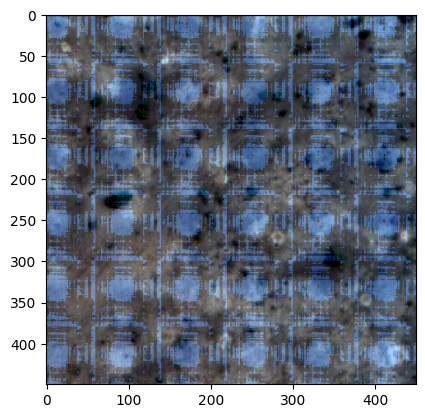

In [ ]:
def CCCscale(x):
  return (x - np.nanpercentile(x,2))/(np.nanpercentile(x,98) - np.nanpercentile(x,2))


with rst.open('/content/three_band/6010_0_0.tif') as src:
  r = src.read(1)[:3345, :3338]
  g = src.read(2)[:3345, :3338]
  b = src.read(3)[:3345, :3338]
  r_scl = CCCscale(r)
  g_scl = CCCscale(g)
  b_scl = CCCscale(b)
  img = cv2.merge((r_scl,g_scl,b_scl))
  alpha = 0.5
  gamma = 0
  print(img.dtype)
  print(mask_rgb.dtype)
  img_result = cv2.addWeighted(img, alpha, mask_rgb, 1 - alpha, gamma)
  # img = np.dstack((r_scl,g_scl,b_scl))
  # cv2_imshow(img[100:550,100:550,:])
  plt.figure()
  plt.imshow(img_result[100:550,100:550,:])
  # plt.show()

# Nueva sección